# DIPY Tutorial - Basic Fiber Tracking

<https://dipy.org/documentation/1.2.0./examples_built/tracking_introduction_eudx/#example-tracking-introduction-eudx>

In [2]:
# imports
import subprocess
import os
import io
import pathlib
import math
import fractions

import numpy as np

# Dipy imports
import dipy
import dipy.io.image
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data

# visualization libraries
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'figure.facecolor': [1.0, 1.0, 1.0, 1.0]})

In [ ]:
# Set up directories
data_dir = pathlib.Path("/srv/tmp/data/pitn/")
subj_dir = data_dir / "101309"
data_files = (
    subj_dir / "T1w/Diffusion/data.nii.gz",
)
f_bval = subj_dir / "T1w/Diffusion/bvals"
f_bvec = subj_dir / "T1w/Diffusion/bvec"

print(subj_dir.exists())
print([data_file.exists() for data_file in data_files])

In [ ]:
mask, mask_affine = load_nifti(str(subj_dir/"T1w/Diffusion/nodif_brain_mask.nii.gz"))
mask.shape

## Copy of Dipy Tutorial

In [3]:
# Enables/disables interactive visualization
interactive = False

from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti, load_nifti_data
from dipy.reconst.csdeconv import auto_response_ssst
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model
from dipy.viz import window, actor, has_fury
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion
from dipy.tracking import utils
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines
from dipy.viz import colormap

In [16]:
hardi_fname, hardi_bval_fname, hardi_bvec_fname = get_fnames('stanford_hardi')
label_fname = get_fnames('stanford_labels')

data, affine, hardi_img = load_nifti(hardi_fname, return_img=True)
print(data.shape, hardi_img.shape)
labels = load_nifti_data(label_fname)
bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
print(bvals.shape, bvecs.shape)
gtab = gradient_table(bvals, bvecs)

(81, 106, 76, 160) (81, 106, 76, 160)
(160,) (160, 3)


(81, 106, 76, 160)


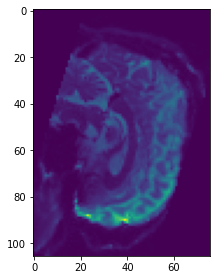

In [109]:
print(data.shape)
plt.imshow(data[40, :, :, 0])

In [101]:
white_matter = (labels == 1) | (labels == 2)

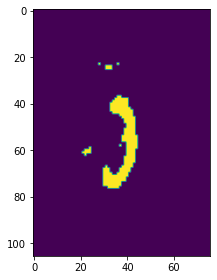

In [104]:
plt.imshow(white_matter[40])

In [110]:
response, ratio = auto_response_ssst(gtab, data, roi_radii=10, fa_thr=0.7)
csa_model = CsaOdfModel(gtab, sh_order=6)
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

(81, 106, 76, 5)


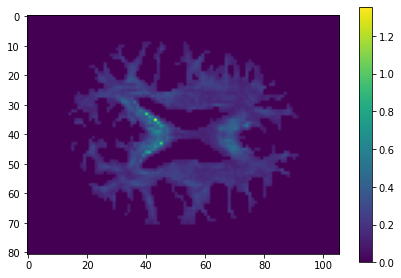

In [134]:
print(csa_peaks.peak_values.shape)
plt.imshow(csa_peaks.peak_values[:, :, 40, 0])
plt.colorbar();

In [133]:
np.pi / 2

1.5707963267948966

In [1]:
# if has_fury:
#     scene = window.Scene()
#     scene.add(actor.peak_slicer(csa_peaks.peak_dirs,
#                                 csa_peaks.peak_values,
#                                 colors=None))

#     window.record(scene, out_path='csa_direction_field.png', size=(900, 900))

#     if interactive:
#         window.show(scene, size=(800, 800))

NameError: name 'has_fury' is not defined

In [7]:
stopping_criterion = ThresholdStoppingCriterion(csa_peaks.gfa, .25)

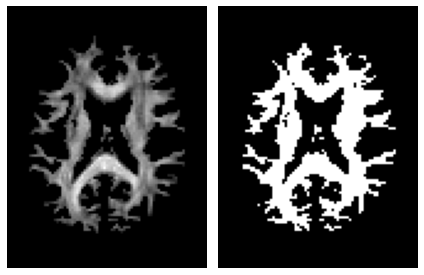

In [135]:
sli = csa_peaks.gfa.shape[2] // 2
plt.figure('GFA')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(csa_peaks.gfa[:, :, sli].T, cmap='gray', origin='lower')

plt.subplot(1, 2, 2).set_axis_off()
plt.imshow((csa_peaks.gfa[:, :, sli] > 0.25).T, cmap='gray', origin='lower')

# plt.savefig('gfa_tracking_mask.png')

In [136]:
seed_mask = (labels == 2)
seeds = utils.seeds_from_mask(seed_mask, affine, density=[2, 2, 2])

In [144]:
# Initialization of LocalTracking. The computation happens in the next step.
streamlines_generator = LocalTracking(csa_peaks, stopping_criterion, seeds,
                                      affine=affine, step_size=.5)
# Generate streamlines object
streamlines = Streamlines(streamlines_generator)


In [153]:
streamlines.get_data()

array([[ -4.5, -44.5,   7.5],
       [ -4.5, -44.5,   7.5],
       [ -4.5, -44.5,   7.5],
       ...,
       [ -0.5,  32.5,  12.5],
       [  0.5,  32.5,  12.5],
       [  0.5,  32.5,  12.5]])

In [ ]:
# if has_fury:
#     # Prepare the display objects.
#     color = colormap.line_colors(streamlines)

#     streamlines_actor = actor.line(streamlines,
#                                    colormap.line_colors(streamlines))

#     # Create the 3D display.
#     scene = window.Scene()
#     scene.add(streamlines_actor)

#     # Save still images for this static example. Or for interactivity use
#     window.record(scene, out_path='tractogram_EuDX.png', size=(800, 800))
#     if interactive:
#         window.show(scene)